In [1]:
import Pkg; Pkg.activate(".")
using JuMP
import Ipopt
using Plots

  Activating project at `~/optimal_control_presentation`


In [2]:
g = 9.81
n = 100
Δt = 1 / n

model = Model(Ipopt.Optimizer)
set_silent(model)
@variables(model, begin
    tf ≥ eps(), (start = 1.0)
    x[1:n]
    y[1:n]
    v[1:n]
    0 ≤ u[1:n] ≤ 2π
end)

fix(x[1], 0.0; force=true)
fix(y[1], 0.0; force=true)
fix(v[1], 0.0; force=true)

fix(x[n], 2.0)
fix(y[n], -2.0)

@NLexpression(model, δx[j=1:n], v[j] * sin(u[j]) * tf)
@NLexpression(model, δy[j=1:n], -v[j] * cos(u[j]) * tf)
@NLexpression(model, δv[j=1:n], g * cos(u[j]) * tf)

for j in 2:n
    # trapezoidal integration
    @NLconstraint(model, x[j] == x[j-1] + Δt * (δx[j-1] + δx[j]) / 2)
    @NLconstraint(model, y[j] == y[j-1] + Δt * (δy[j-1] + δy[j]) / 2)
    @NLconstraint(model, v[j] == v[j-1] + Δt * (δv[j-1] + δv[j]) / 2)
end
@constraint(model, x[n] == 2.0)
@constraint(model, y[n] == -2.0)

@objective(model, Min, tf)
model

A JuMP Model
Minimization problem with:
Variables: 401
Objective function type: VariableRef
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 5 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 101 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 100 constraints
Nonlinear: 297 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt
Names registered in the model: tf, u, v, x, y, δv, δx, δy

In [3]:
optimize!(model)
solution_summary(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



* Solver : Ipopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 8.32670e-01
  Dual objective value : 4.16335e-01

* Work counters
  Solve time (sec)   : 5.18433e+00


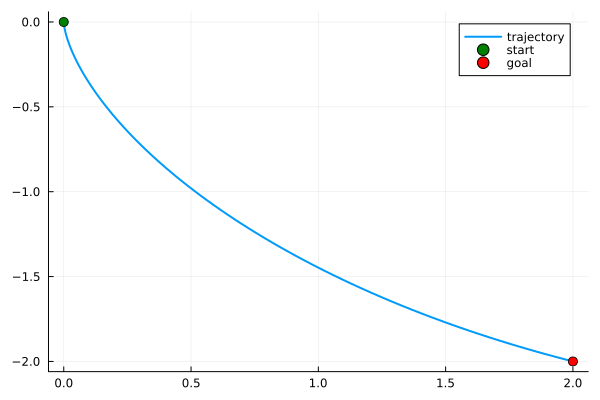

In [17]:
plot(value.(x), value.(y), label="trajectory", lw=2)
scatter!([0], [0], label="start", color=:green, ms=5)
scatter!([2], [-2], label="goal", color=:red, ms=5)